# Analysis of the Electrical Conductivity of Dissolved Rock Samples

1) die Leitfähigkeit ist der Kehrwehrt des Widerstandes der Lösung, also alles was auch bildlich den Widerstand erhöht, verringert die LF. (Große Moleküle zb)
2) die LF ist ein Summenparameter. Es kann nicht in einzelne Ladungsträger differenziert werden, sondern nur ein Gesamtwert ermittelt werden.
3) in die LF geht die Wertigkeit, die Mobilität, die Geschwindigkeit und die Konzentrationen der Ionen ein.
4) die LF steigt zunächt mit steigender Konzentration der Ladungsträger auf ein Maximum und sinkt dann wieder

Das zur Leitfähigkeit.
In meinem Versuch passieren mehrere Dinge, die nicht definierbare aber unterschiedliche Auswirkungen auf die LF haben.Deswegen habe ich die ganzen Prozesse zusammengefasst in Prozesse, die sich positiv und Prozesse, die sich negativ auf die LF auswirken. Ich hab dir nun doch  noch mal n Paper von der letzten Konzferenz angehängt. Das finde ich zwar Kacke, gibt aber ggf n guten Überblick. Die Auswertungen würde ich inzwischen allerdings auch streichen.
Was sich aber gezeigt hat ,ist dass es zwar für einige Steine mit nur einer Reaktionskonstante fünktioniert für Opalsandstein aber zb nicht.

1) Das pulver reagiert mit Hydroxidionen und so lösen sich aus dem Festkörper Monokieselsäure Spezies. Das verbraucht OH-, setzt aber nach maximal vier Reaktionen des Festkörpers mit den OH- ein Molekül in die Lösung frei. ALso weniger Partikel in der Lösung, dafür ein größeres.....
2) Wenn ausreichend Monokieselsäure in der Lösung ist, dann kondensiert diese. Das setzt Hydroxidionen frei. also gleiche Anzahl an Partikeln, aber größere Partikel
3) die Neutrale Monokieselsäure deprotoniert, gibt also ein H+ ab idr an ein OH- also mehr Ladungsträger in der Lösung....

Gydes Konferenz Paper zum Thema <a href='Ibausil_Hartmut_2023_1.pdf'>Hier</a>. <br>
Gydes Cloud Speicher mit den Daten <a href='https://cloud.tuhh.de/index.php/s/iY6J5fkpH64qPgr'>Hier</a>. 

## Imports and Definitions

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import time
import json

from glob import glob
from scipy.optimize import curve_fit
from scipy.stats import norm
from collections import Counter

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from io import StringIO
import pydotplus

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

In [3]:
# exponential decay function to describe the decrease in conductivity
lf = lambda t, dlf, k, lf1, m=0: dlf * np.exp(-t/k) + m*t + lf1

In [34]:
# load the BET values for the different sample types
with open('raw/bet.json') as f:
    bet = json.load(f)

## Check Timing

sampling time: (30 +/- 4) s


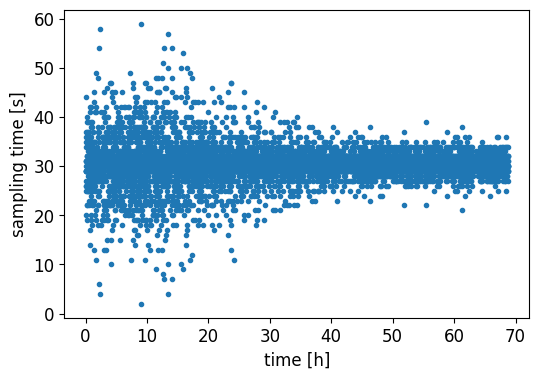

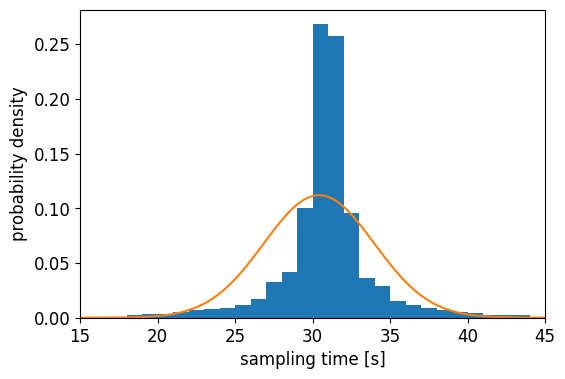

In [25]:
filename = 'raw/timingData/10g Flint.csv'
filename = 'raw/timingData/20200106_OSSN_10g_50C.csv'
filename = 'raw/timingData/20210104_FlintNB_5g_60C.csv'

# load the data file with the full time stamp
df = pd.read_csv(filename).drop([0])

# load date and time and merge them
dateTime = np.asarray([df['Datum'],df['Zeitpunkt']]).T
dateTime = np.asarray([' '.join(dateTime[i]) for i in range(len(df))])

# convert date and time to UNIX timestamp
dateTime = np.asarray([time.mktime(time.strptime(dateTime[i], '%d/%m/%Y %H:%M:%S')) for i in range(len(df)-1)])
#dateTime = dateTime[len(dateTime)//2:]

# calculate the sampling time
samplingTime = np.diff(dateTime)
timePDF = np.linspace(samplingTime.min(), samplingTime.max(), 10001)
bins = np.arange(samplingTime.min(), samplingTime.max()+1, 1)
print('sampling time: ({:.0f} +/- {:.0f}) s'.format(samplingTime.mean(), samplingTime.std()))

# show the time course of the sampling time
fig, ax = plt.subplots()
ax.plot((dateTime[:-1]-dateTime[0])/3600, samplingTime, '.')
ax.set(xlabel='time [h]', ylabel='sampling time [s]')
plt.show()

# show the sampling time histogram and normal distribution
fig, ax = plt.subplots()
ax.hist(samplingTime, bins, density=True)
ax.plot(timePDF, norm(loc=samplingTime.mean(), scale=samplingTime.std()).pdf(timePDF))
ax.set(xlabel='sampling time [s]', ylabel='probability density', xlim=(15, 45))
plt.show()

## Test Set

In [38]:
# sampling time in [h]
# this is an average and could be calculated for each sample
samplingTime = 30 / 3600

In [39]:
sample = 'MS'
weight = '03g'
ID = np.array([10, 11, 68, 69, 82, 83, 504])

sample = 'MS'
weight = '05g'
ID = np.array([13,14,22,24,25,39,47])

sample = 'MS'
weight = '08g'
ID = np.array([98,99])

sample = 'MS'
weight = '10g'
ID = np.array([1, 2, 3, 7, 20, 23, 80, 81, 104, 105, 5, 6])

sample = 'FLINTAD'
weight = '03g'
ID = np.array([154,155,166,167,178,179])

sample = 'FLINTAD'
weight = '05g'
ID = np.array([136,137,138,139,176,177,216,217])

sample = 'FLINTAD'
weight = '08g'
ID = np.array([182,183,196,197])

sample = 'FLINTAD'
weight = '10g'
ID = np.array([144,145,188,189,200,201])

sample = 'FLINTAD'
weight = '12g'
ID = np.array([180,181,184,185])

sample = 'OSSH'
weight = '03g'
ID = np.array([497,498,499,500,501])

sample = 'OSSH'
weight = '05g'
ID = np.array([66,67,76,77,114,115,116,117,118,119,122,123])

sample = 'OSSH'
weight = '08g'
ID = np.array([106,107,108,109,110,111,112,113])

sample = 'OSSH'
weight = '10g'
ID = np.array([62,63,64,65,73])

sample = 'FLINTNB'
weight = '03g'
ID = np.array([146,147,160,161,226,227,230,231,234,235,238,239,242,243])

sample = 'FLINTNB'
weight = '05g'
ID = np.array([134,135,152,153,158,159])

sample = 'FLINTNB'
weight = '08g'
ID = np.array([140,141,162,163,168,169,212,213])

sample = 'FLINTNB'
weight = '10g'
ID = np.array([150,151,170,171,192,193,194,195])

sample = 'OSSN'
weight = '03g'
ID = np.array([9,92,93,94,95])

sample = 'OSSN'
weight = '05g'
temp = ''
ID = np.array([42,43,44,45,57])

sample = 'OSSN'
weight = '05g'
temp = ''
ID = np.array([28,29,30,31,50,51,60,61])

sample = 'OSSN'
weight = '08g'
ID = np.array([52,53,54,55])

sample = 'OSSN'
weight = '10g'
temp = ''
ID = np.array([36,37,40,41,58,59])    

sample = 'OSSN'
weight = '10g'
temp = ''
ID = np.array([26,27,48,49]) 

sample = 'OSSN'
weight = '12g'
ID = np.array([32,33,74,75,84,85,86,87]) 

sample = 'GWGT'
weight = '03g'
ID = np.array([288,289,290,291,292,293,295])

sample = 'GWGT'
weight = '05g'
ID = np.array([204,205,224,225,229,240,241,246,248,365,367,371])

sample = 'GWGT'
weight = '08g'
ID = np.array([256,257,258,259,260,261,274,373])

sample = 'GWGT'
weight = '10g'
ID = np.array([402, 403, 404, 405, 406, 407, 419])

sample = 'GWGT'
weight = '12g'
ID = np.array([306,307,308,309])

sample = 'GWHZ'
weight = '03g'
ID = np.array([296, 297, 298, 299, 301])

sample = 'GWHZ'
weight = '05g'
ID = np.array([244, 245, 250, 251, 254, 255, 379])

sample = 'GWHZ'
weight = '08g'
ID = np.array([262, 263, 264, 265, 266])

sample = 'GWHZ'
weight = '10g'
ID = np.array([408, 409, 410, 411, 412, 413, 417])

sample = 'GWHZ'
weight = '12g'
ID = np.array([304, 305])

sample = 'GWOS'
weight = '03g'
ID = np.array([280, 281, 282, 283, 284, 285, 286, 287])

sample = 'GWOS'
weight = '05g'
ID = np.array([220, 221, 222, 223, 232, 233, 247, 252, 253])

sample = 'GWOS'
weight = '05g'
ID = np.array([220, 221, 222, 223, 232, 233, 247, 252, 253])

sample = 'GWOS'
weight = '08g'
ID = np.array([268, 269, 270, 272, 276, 277])

sample = 'GWOS'
weight = '10g'
ID = np.array([394, 395, 398, 399, 400, 401])

- MS_5g changed order of columns, wrong lengths, shifted entries
- OSSN_5g_50C only negative times
- OSSN_8g a lot of reformating (text to numbers, dates to numbers)
- bad samples: 17, 18, 21, 88, 104, 145, 180, 497, 500, 114, 116, 118, 122, 110, 100, 101, 8, 29, 53, 54, 55, 58, 33

In [84]:
sample = 'GWGT'
weight = '08g'
ID = np.array([256,257,258,259,260,261,274,373])

# initial fitting parameter, seem to work for everything
popt = (5, 2, 100, -1)

# create the filename
filename = 'raw/{}_{}_LF.xlsx'.format(sample, weight)

# load the filename into a dataframe
df = pd.read_excel(filename)

# show the columns and the first few lines
print(df.columns)

# define the time array
Time_h = df['Unnamed: 0']*samplingTime

df.head()

Index(['Unnamed: 0', 256, 257, 258, 259, 260, 261, 274, 373], dtype='object')


,Unnamed: 0,256,257,258,259,260,261,274,373
0,-1000.0,43.1,26.1,53.9,26.7,61.4,33.6,61.2,54.6
1,-999.0,43.1,26.1,53.9,26.7,61.4,33.6,61.2,54.6
2,-998.0,43,26.1,53.9,26.7,61.4,33.6,61.2,54.6
3,-997.0,43.1,26.1,53.9,26.7,61.4,33.5,61.2,54.6
4,-996.0,43.1,26.1,53.9,26.7,61.4,33.6,61.2,54.6


/home/sivo/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


k	=	(0.53 +/- 0.00) h
lf0	=	(42.98 +/- 0.16) mS/cm
lf0	=	(44.40 +/- 0.05) mS/cm
lf1	=	(35.96 +/- 0.01) mS/cm
dlf	=	(8.44 +/- 0.05) mS/cm
dlfr	=	(0.19 +/- 0.00) mS/cm
m	=	(0.05 +/- 0.00) mS/cm/h
prob	=	0.01


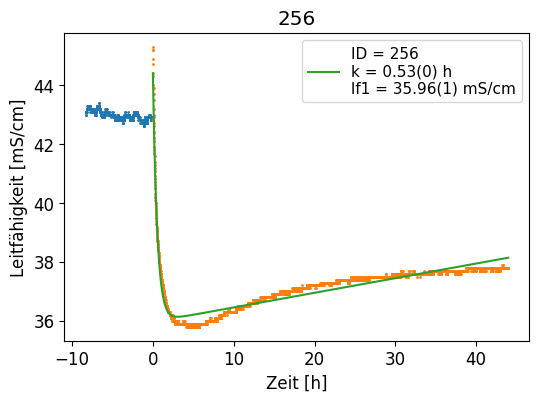

k	=	(1.67 +/- 0.01) h
lf0	=	(25.96 +/- 0.15) mS/cm
lf0	=	(25.29 +/- 0.02) mS/cm
lf1	=	(21.99 +/- 0.00) mS/cm
dlf	=	(3.30 +/- 0.02) mS/cm
dlfr	=	(0.13 +/- 0.00) mS/cm
m	=	(-0.04 +/- 0.00) mS/cm/h
prob	=	0.00


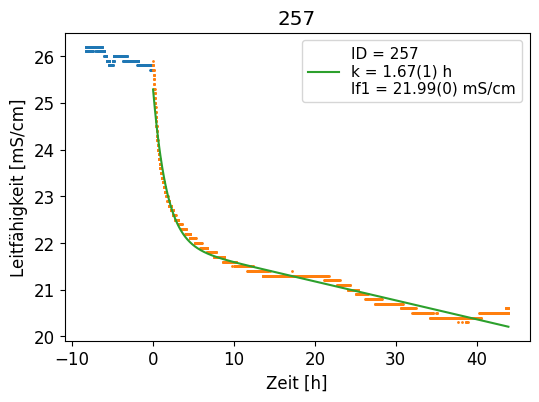

k	=	(1.19 +/- 0.01) h
lf0	=	(53.68 +/- 0.16) mS/cm
lf0	=	(55.94 +/- 0.03) mS/cm
lf1	=	(50.90 +/- 0.00) mS/cm
dlf	=	(5.04 +/- 0.03) mS/cm
dlfr	=	(0.09 +/- 0.00) mS/cm
m	=	(0.01 +/- 0.00) mS/cm/h
prob	=	0.00


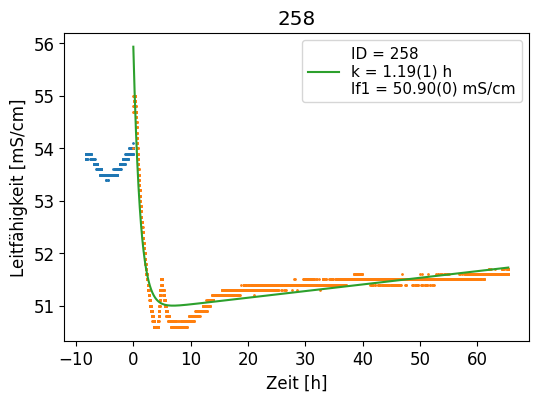

k	=	(0.32 +/- 0.01) h
lf0	=	(26.39 +/- 0.21) mS/cm
lf0	=	(25.28 +/- 0.05) mS/cm
lf1	=	(20.96 +/- 0.00) mS/cm
dlf	=	(4.31 +/- 0.05) mS/cm
dlfr	=	(0.17 +/- 0.00) mS/cm
m	=	(0.01 +/- 0.00) mS/cm/h
prob	=	0.01


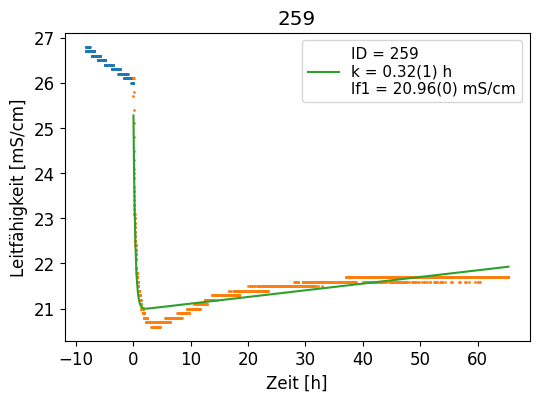

k	=	(0.62 +/- 0.01) h
lf0	=	(61.66 +/- 0.13) mS/cm
lf0	=	(65.69 +/- 0.09) mS/cm
lf1	=	(52.21 +/- 0.01) mS/cm
dlf	=	(13.48 +/- 0.09) mS/cm
dlfr	=	(0.21 +/- 0.00) mS/cm
m	=	(0.05 +/- 0.00) mS/cm/h
prob	=	0.01


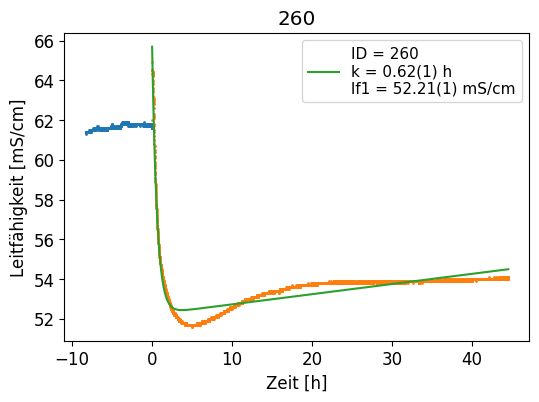

k	=	(2.03 +/- 0.03) h
lf0	=	(33.26 +/- 0.30) mS/cm
lf0	=	(31.64 +/- 0.05) mS/cm
lf1	=	(26.19 +/- 0.02) mS/cm
dlf	=	(5.45 +/- 0.05) mS/cm
dlfr	=	(0.17 +/- 0.00) mS/cm
m	=	(-0.00 +/- 0.00) mS/cm/h
prob	=	0.01


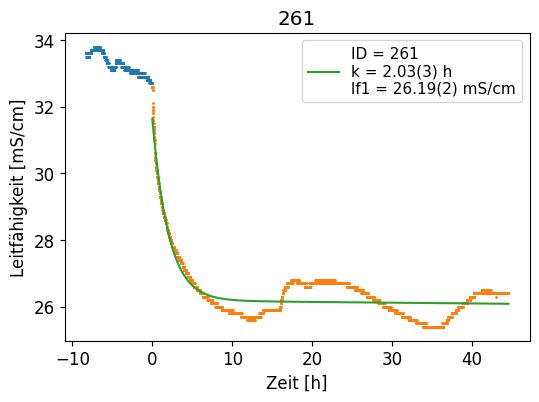

k	=	(0.95 +/- 0.00) h
lf0	=	(61.18 +/- 0.06) mS/cm
lf0	=	(64.06 +/- 0.04) mS/cm
lf1	=	(52.15 +/- 0.01) mS/cm
dlf	=	(11.90 +/- 0.04) mS/cm
dlfr	=	(0.19 +/- 0.00) mS/cm
m	=	(0.01 +/- 0.00) mS/cm/h
prob	=	0.00


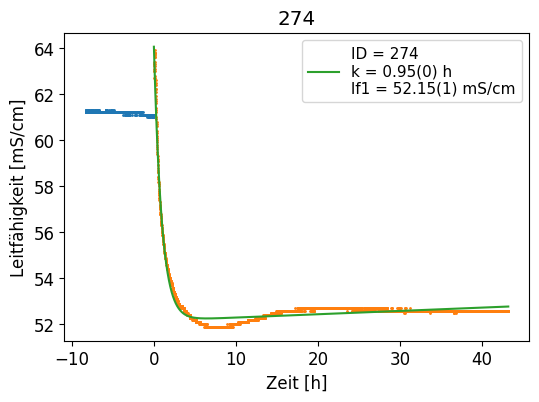

k	=	(1.27 +/- 0.01) h
lf0	=	(54.37 +/- 0.17) mS/cm
lf0	=	(55.10 +/- 0.03) mS/cm
lf1	=	(47.15 +/- 0.01) mS/cm
dlf	=	(7.95 +/- 0.03) mS/cm
dlfr	=	(0.14 +/- 0.00) mS/cm
m	=	(0.02 +/- 0.00) mS/cm/h
prob	=	0.00


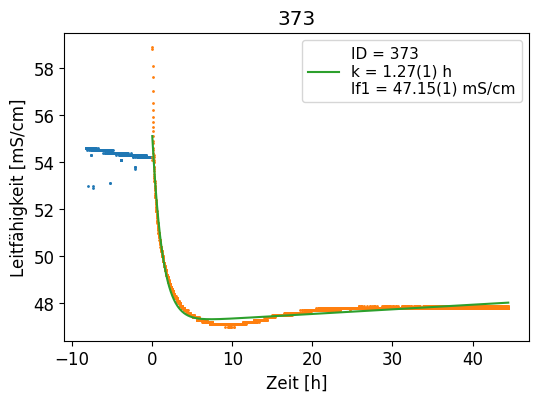

In [85]:
N = len(ID)

lf0_mean = np.zeros((2,N))

dlf_fit = np.zeros((2,N))
k_fit = np.zeros((2,N))
lf1_fit = np.zeros((2,N))
m_fit = np.zeros((2,N))

lf0_calc = np.zeros((2,N))
dlf_rel_calc = np.zeros((2,N))

problem = np.zeros(N)

for i,id in enumerate(ID):

    # select data to calculate lf0_mean
    mask_m  = (Time_h<0)
    lf0_mean[:,i] = df[id][mask_m].mean(), df[id][mask_m].std()
    
    # select data and perform the fit
    mask = (Time_h>=0) & (df[id].notna()) & (df[id]!=' ')
    popt, pcov = curve_fit(lf, Time_h[mask], df[id][mask], p0=popt, maxfev=100000)
    perr = np.sqrt(np.diag(pcov))

    # save the fitted parameters into the corresponding variable
    dlf_fit[:,i] = popt[0], perr[0]
    k_fit[:,i] = popt[1], perr[1]
    lf1_fit[:,i] = popt[2], perr[2]
    m_fit[:,i] = popt[3], perr[3]

    # calculate the derived parameters
    lf0_calc[:,i] = popt[0]+popt[2], np.sqrt(perr[0]**2+perr[2]**2)
    dlf_rel_calc[:,i] = popt[0]/(popt[0]+popt[2]), np.sqrt((popt[0]**2*perr[2]**2+popt[2]**2*perr[0]**2)/(popt[0]+popt[2])**4)

    # calculate the average relative error
    problem[i] = np.mean(perr[:-1]/abs(popt[:-1]))

    # print the relevant fitted parameters
    print('k\t=\t({:.2f} +/- {:.2f}) h'.format(*k_fit[:,i]))
    print('lf0\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*lf0_mean[:,i]))
    print('lf0\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*lf0_calc[:,i]))
    print('lf1\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*lf1_fit[:,i]))
    print('dlf\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*dlf_fit[:,i]))
    print('dlfr\t=\t({:.2f} +/- {:.2f}) mS/cm'.format(*dlf_rel_calc[:,i]))
    print('m\t=\t({:.2f} +/- {:.2f}) mS/cm/h'.format(*m_fit[:,i]))
    print('prob\t=\t{:.2f}'.format(problem[i]))
    
    # create the label for the figure
    label = 'ID = {}\nk = {:.2f}({:.0f}) h\nlf1 = {:.2f}({:.0f}) mS/cm'.format(id, popt[1], 1e2*perr[1], popt[2], 1e2*perr[2])

    # plot and save the figure
    fig, ax = plt.subplots()
    ax.plot(Time_h[mask_m], df[id][mask_m], '.', ms=2)
    ax.plot(Time_h[mask], df[id][mask], '.', ms=2)
    ax.plot(Time_h[mask], lf(Time_h[mask], *popt), '-', label=label)
    ax.legend(loc='upper right')
    ax.set(title=id, xlabel='Zeit [h]', ylabel='Leitfähigkeit [mS/cm]')
    fig.savefig('plots/{:04d}.png'.format(id))
    plt.show()

In [86]:
data = np.concatenate((ID,[sample for x in range(N)],[weight for x in range(N)],*lf0_mean,*lf0_calc,*lf1_fit,*dlf_fit,*dlf_rel_calc,*k_fit,*m_fit))
data = data.reshape((len(data)//len(ID),len(ID)))

In [87]:
header = 'id,sample,weight,lf0_mean,lf0_mean_err,lf0_calc,lf0_calc_err,lf1_fit,lf1_fit_err,dlf_fit,dlf_fit_err,dlf_rel_calc,dlf_rel_calc_err,k_fit,k_fit_err,m_fit,m_fit_err'
fmt='%s'

np.savetxt('processed/{}.csv'.format(filename[4:-5]), data.T, fmt=fmt, header=header, delimiter=',')

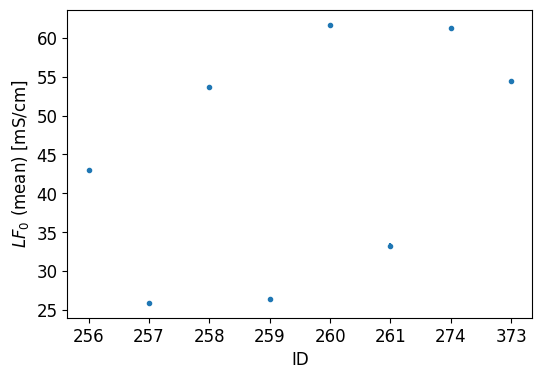

In [88]:
fig, ax = plt.subplots()
ax.errorbar([str(id) for id in ID], *lf0_mean, fmt='.')
ax.set(xlabel='ID', ylabel='$LF_0$ (mean) [mS/cm]')
plt.show()

## Combine Files

In [133]:
filenames = sorted(glob('processed/*08g*_LF.csv'))

for f in filenames:
    df = pd.read_csv(f)
    df.weight = '08g'
    df.to_csv(f, index=False)

In [134]:
# get all files in the processed directory
filenames = sorted(glob('processed/*_LF.csv'))

# combine their content
df_all = pd.concat([pd.read_csv(f) for f in filenames])

# save into new file
df_all.to_csv('processed/combinedData.csv', index=False)

In [135]:
# check for duplicate IDs
numberOfIDs = len(df_all['# id'])
numberOfUniqueIDs = len(set(df_all['# id']))
duplicateIDs = [k for k,v in Counter(df_all['# id']).items() if v>1]
print('number of duplicate IDs: {}'.format(numberOfIDs-numberOfUniqueIDs))
print('IDs:', duplicateIDs)

number of duplicate IDs: 0
IDs: []


## Machine Learning Shizzle

### Preprocessing

In [317]:
df_all = pd.read_csv('processed/combinedData.csv', delimiter=',')
print(df_all.shape)
df_all.head()

(275, 17)


,# id,sample,weight,lf0_mean,lf0_mean_err,lf0_calc,lf0_calc_err,lf1_fit,lf1_fit_err,dlf_fit,dlf_fit_err,dlf_rel_calc,dlf_rel_calc_err,k_fit,k_fit_err,m_fit,m_fit_err
0,154,FLINTAD,03g,42.8431,0.153349,42.292895,0.020894,39.439602,0.015590,2.853294,0.013911,0.067465,0.000308,7.023144,0.071792,-0.045374,0.000437
1,155,FLINTAD,03g,57.1019,0.316080,56.306432,0.015723,51.816623,0.010472,4.489809,0.011729,0.079739,0.000192,4.948270,0.029825,-0.060779,0.000329
2,166,FLINTAD,03g,63.7588,0.240833,64.289115,0.020145,59.835045,0.009974,4.454070,0.017502,0.069282,0.000254,3.368527,0.027236,-0.095268,0.000342
3,167,FLINTAD,03g,53.5582,0.230317,52.724526,0.013420,48.378353,0.009455,4.346173,0.009523,0.082432,0.000166,5.560296,0.028117,-0.084324,0.000287
4,178,FLINTAD,03g,67.2073,0.204887,66.372145,0.033404,61.924517,0.023165,4.447629,0.024068,0.067010,0.000339,5.358453,0.067123,-0.100920,0.000711


In [318]:
BET = [bet[sample] for sample in df_all['sample']]

In [319]:
df_all.k_fit = df_all.k_fit / BET

In [320]:
# select features to be included
features = ['weight','lf0_mean','lf0_calc','lf1_fit','k_fit']
#features = ['lf0_mean','lf0_calc','lf1_fit','k_fit']

X = df_all[features].values
X[0:5]

array([['03g', 42.84309999999957, 42.29289541512848, 39.439601883728095,
        0.9120965600458953],
       ['03g', 57.101900000000285, 56.30643234153009, 51.81662288858136,
        0.6426324234091684],
       ['03g', 63.758799999999866, 64.28911529971612, 59.835045310606205,
        0.43747098103305765],
       ['03g', 53.55820000000022, 52.7245262145943, 48.37835294497816,
        0.7221163229631716],
       ['03g', 67.20729999999976, 66.37214530602509, 61.92451668707978,
        0.6959030213939938]], dtype=object)

In [321]:
# encode features
le_weight = preprocessing.LabelEncoder()
le_weight.fit(['03g','05g','08g','10g','12g'])
X[:,0] = le_weight.transform(X[:,0])
X[0:5]

array([[0, 42.84309999999957, 42.29289541512848, 39.439601883728095,
        0.9120965600458953],
       [0, 57.101900000000285, 56.30643234153009, 51.81662288858136,
        0.6426324234091684],
       [0, 63.758799999999866, 64.28911529971612, 59.835045310606205,
        0.43747098103305765],
       [0, 53.55820000000022, 52.7245262145943, 48.37835294497816,
        0.7221163229631716],
       [0, 67.20729999999976, 66.37214530602509, 61.92451668707978,
        0.6959030213939938]], dtype=object)

In [323]:
# normalize the features
# especially important for KNN
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-1.33755249e+00, -7.76149942e-01, -8.05221162e-01,
        -4.52376307e-01,  1.76339783e-01],
       [-1.33755249e+00, -1.29246045e-01, -1.54194407e-01,
         2.14223304e-02, -4.34708130e-02],
       [-1.33755249e+00,  1.72769171e-01,  2.16657021e-01,
         3.28371605e-01, -2.10827625e-01],
       [-1.33755249e+00, -2.90019275e-01, -3.20598987e-01,
        -1.10196386e-01,  2.13667700e-02],
       [-1.33755249e+00,  3.29223297e-01,  3.13428326e-01,
         4.08357628e-01, -1.62664045e-05]])

In [324]:
# define target variable
y = df_all['sample']
y.head()

0    FLINTAD
1    FLINTAD
2    FLINTAD
3    FLINTAD
4    FLINTAD
Name: sample, dtype: object

In [325]:
# split the data into a train and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Decision Tree

In [326]:
# setup the decision tree and train
sampleTree = DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X_train, y_train)

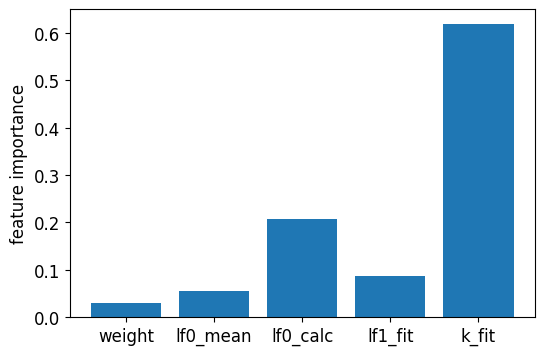

In [327]:
# get the feature importance and show them
featureImportance = sampleTree.feature_importances_

fig, ax = plt.subplots()
ax.bar(features, featureImportance)
ax.set(ylabel='feature importance')
plt.show()

In [328]:
# predict some samples
predTree = sampleTree.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['MS' 'FLINTAD' 'FLINTAD' 'GWHZ' 'MS']
['OSSH' 'GWGT' 'GWOS' 'GWOS' 'MS']


In [329]:
# check accuracy of model
print('decision trees accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

decision trees accuracy: 54.5%


### K nearest neighbor (KNN)

In [281]:
# train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)

In [282]:
# predict some samples
predTree = neigh.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['OSSH' 'GWGT' 'GWOS' 'GWGT' 'MS']
['OSSH' 'GWGT' 'GWOS' 'GWOS' 'MS']


In [283]:
# check accuracy of model
print('KKN accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

KKN accuracy: 48.2%


### Logistic Regression

In [284]:
LR = LogisticRegression(C=0.5, solver='liblinear').fit(X_train,y_train)

In [285]:
# predict some samples
predTree = LR.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['OSSH' 'GWOS' 'MS' 'GWHZ' 'MS']
['OSSH' 'GWGT' 'GWOS' 'GWOS' 'MS']


In [286]:
# check accuracy of model
print('Logistic regression accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

Logistic regression accuracy: 39.8%


### Support Vector Machine SVM

In [287]:
clf = svm.SVC(kernel='rbf').fit(X_train, y_train) 

In [288]:
# predict some samples
predTree = clf.predict(X_test)

# compare some predictions with the true values
print(predTree[0:5])
print(y_test[0:5].values)

['OSSH' 'GWOS' 'FLINTAD' 'GWHZ' 'MS']
['OSSH' 'GWGT' 'GWOS' 'GWOS' 'MS']


In [289]:
# check accuracy of model
print('SVM accuracy: {:.1f}%'.format(100*metrics.accuracy_score(y_test, predTree)))

SVM accuracy: 42.2%
